**Load Libraries**

In [1]:
import os
from typing import NoReturn, Any

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from mlxtend.plotting import plot_confusion_matrix

**Paths**

In [2]:
BASE_PATH = "../../"
MONITORING = os.path.join(BASE_PATH, "logs")
DATA = os.path.join(BASE_PATH, "data")

In [3]:
CHECKPOINT_PATH = os.path.join(MONITORING, "checkpoints")
CNN_CHECKPOINT_PATH = os.path.join(CHECKPOINT_PATH, "cnn")
RNN_CHECKPOINT_PATH = os.path.join(CHECKPOINT_PATH, "rnn")

In [4]:
TENSORBOARD_LOG_DIR = os.path.join(MONITORING, "tensorboard_logs")
CNN_TENSORBOARD_LOGS = os.path.join(TENSORBOARD_LOG_DIR, "cnn")
RNN_TENSORBOARD_LOGS = os.path.join(TENSORBOARD_LOG_DIR, "rnn")

In [5]:
CSV_LOG_DIR = os.path.join(MONITORING, "csv_logs")
CNN_CSV_LOGS = os.path.join(CSV_LOG_DIR, "cnn")
RNN_CSV_LOGS = os.path.join(CSV_LOG_DIR, "rnn")

In [6]:
TUNERS = os.path.join(DATA, "tuners")
MODELS = os.path.join(DATA, "models")

**GPU/TPU Multithreading Setup**

In [7]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy
except ValueError:
    strategy = tf.distribute.get_strategy()
    print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [8]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

In [9]:
if tpu:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(
        tpu,
    )
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
elif len(gpus) > 1:
    strategy = tf.distribute.MultiWorkerMirroredStrategy([gpu.name for gpu in gpus])
    print("Running on multiple GPUs ", [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print("Running on single GPU ", gpus[0].name)
else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


**Hyperparameters**

In [10]:
# Adjustable
BATCH_SIZE = 32  # Big batch size, small learning rate
HEIGHT, WIDTH = 224, 224
IMG_SIZE = (HEIGHT, WIDTH)
IMG_FORMAT = (HEIGHT, WIDTH, 3)
EPOCHS = 1000
TRIALS = 20
SEED = 949953915

**Load Dataset**

In [11]:
train_dataset, val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../../data/dataset/img/mfcc",
    validation_split=0.2,
    subset="both",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 34995 files belonging to 6 classes.
Using 27996 files for training.
Using 6999 files for validation.


In [12]:
class_names = train_dataset.class_names
num_classes = len(class_names)

**Dataset Representation**

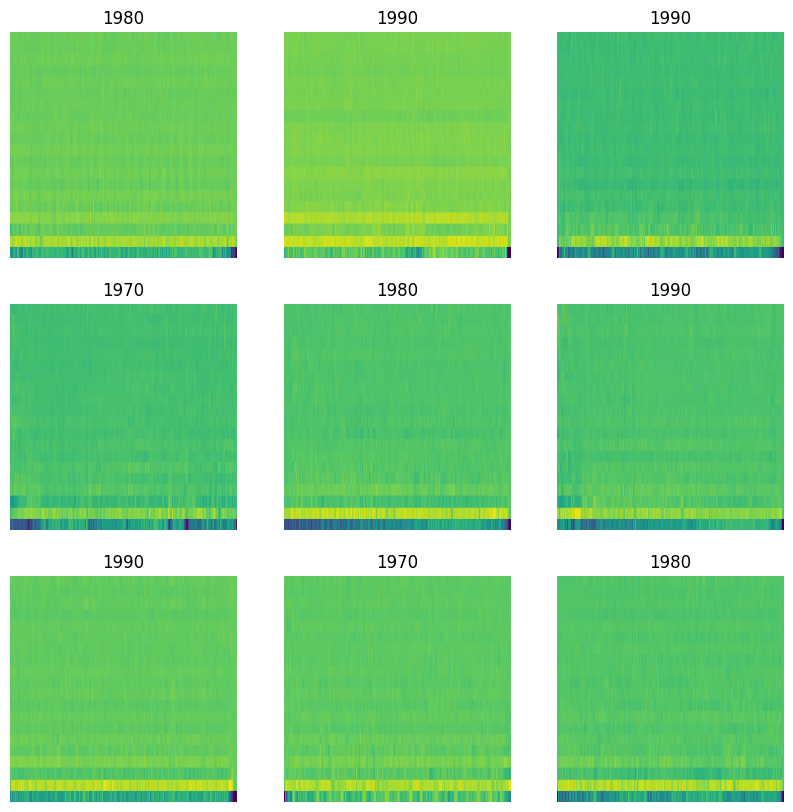

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Preprocessing**

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

In [16]:
with strategy.scope():    
    normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))

**CNN**

In [17]:
def cnn(hp: kt.HyperParameters) -> tf.keras.Sequential:
    inputs = tf.keras.Input(shape=IMG_FORMAT)
    x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
    )(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(
        filters=hp.Int("conv_2_filter", min_value=64, max_value=256, step=8),
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
    )(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(
        filters=hp.Int("conv_3_filter", min_value=128, max_value=1024, step=8),
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
    )(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(
        rate=hp.Float(
            "dropout_1",
            min_value=0.0,
            max_value=0.5,
            default=0.25,
            step=0.05,
        )
    )(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(
        units=hp.Int("dense_1_units", min_value=32, max_value=128, step=8),
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
    )(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3])
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

**Utilitary For Monitoring**

In [18]:
stop_early = [
    {
        "monitor": "val_loss",
        "patience": 50,
        "min_delta": 0.001,
        "mode": "min",
        "verbose": 1,
        "restore_best_weights": True,
    },
    {
        "monitor": "val_accuracy",
        "patience": 50,
        "min_delta": 0.001,
        "mode": "max",
        "verbose": 1,
        "restore_best_weights": True,
    },
]
stop_early = [tf.keras.callbacks.EarlyStopping(**condition) for condition in stop_early]

In [19]:
def path_exists(path: str) -> str:
    if os.path.exists(path):
        if path[-1].isdigit():
            suffix = path[: path.rfind("_")]
            digits = int(path[path.rfind("_") + 1 :])
            path = f"{suffix}_{digits + 1}"
        else:
            path = f"{path}_0"
    return path

In [20]:
def model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=path_exists(
            f"{globals()[f'{model_name.upper()}_CHECKPOINT_PATH']}/"
            f"BS_{BATCH_SIZE}"
            f"_LR_{SEED}"
            f"_EPOCHS_{EPOCHS}"
            f"_TRIALS_{TRIALS}"
        ),
        save_weights_only=False,
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
    )

In [21]:
def tensorboard_logs(model_name: str) -> tf.keras.callbacks.TensorBoard:
    return tf.keras.callbacks.TensorBoard(
        path_exists(
            f"{globals()[f'{model_name.upper()}_TENSORBOARD_LOGS']}/"
            f"BS_{BATCH_SIZE}"
            f"_LR_{SEED}"
            f"_EPOCHS_{EPOCHS}"
            f"_TRIALS_{TRIALS}"
        )
    )

In [22]:
def epochs_logs(model_name: str) -> tf.keras.callbacks.CSVLogger:
    path = (
        f"{globals()[f'{model_name.upper()}_CSV_LOGS']}/"
        f"BS_{BATCH_SIZE}"
        f"_LR_{SEED}"
        f"_EPOCHS_{EPOCHS}"
        f"_TRIALS_{TRIALS}"
    )
    return tf.keras.callbacks.CSVLogger(f"{path_exists(path)}.csv")

**Training**

In [23]:
def training(model: Any) -> NoReturn:
    model_name = model.__name__
    with strategy.scope():
        tuner = kt.BayesianOptimization(
            hypermodel=model,
            objective=kt.Objective("val_accuracy", direction="max"),
            max_trials=TRIALS,
            overwrite=True,
            project_name=path_exists(f"{TUNERS}\\{model_name}_tuner"),
            directory=path_exists("{TUNERS}_{model_name}"),
        )

        # Search for best hyperparameters
        tuner.search(
            train_dataset,
            epochs=EPOCHS,
            validation_data=val_dataset,
            callbacks=[
                stop_early,
                model_checkpoint(model_name),
                epochs_logs(model_name),
                tensorboard_logs(model_name),
            ],
        )
        # Get the optimal hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

        # Build model with optimal hyperparameters
        model = tuner.hypermodel.build(best_hps)
        history = model.fit(
            train_dataset,
            epochs=EPOCHS,
            validation_data=val_dataset,
            callbacks=[
                stop_early,
                model_checkpoint(model_name),
                epochs_logs(model_name),
                tensorboard_logs(model_name),
            ],
        )
        val_acc_per_epoch = history.history["val_accuracy"]
        best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
        print(f"best_epoch : {best_epoch}")

        hypermodel = tuner.hypermodel.build(best_hps)
        # Retrain the model with epoch with highest val_accuracy value
        hypermodel.fit(
            train_dataset,
            epochs=best_epoch,
            validation_data=val_dataset,
            callbacks=[
                stop_early,
                model_checkpoint(model_name),
                epochs_logs(model_name),
                tensorboard_logs(model_name),
            ],
        )

        eval_result = hypermodel.evaluate(val_dataset)

        hypermodel.save(
            f"{MODELS}\\"
            f"{model_name}"
            f"_loss_{eval_result[0]}"
            f"_acc_{eval_result[1]}"
            f"_best_epoch_{best_epoch}"
            f"_img_size_{IMG_SIZE}"
        )

In [24]:
training(cnn)

Trial 2 Complete [02h 19m 57s]
val_accuracy: 0.3407629728317261

Best val_accuracy So Far: 0.36333760619163513
Total elapsed time: 05h 43m 49s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
112               |192               |conv_2_filter
584               |352               |conv_3_filter
0                 |0.45              |dropout_1
88                |112               |dense_1_units
0.001             |0.001             |learning_rate

Epoch 1/1000
  6/875 [..............................] - ETA: 1:00 - loss: 6.7845 - accuracy: 0.2031WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0460s). Check your callbacks.


875/875 [==============================] - ETA: 0s - loss: 1.9645 - accuracy: 0.2192

INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


875/875 [==============================] - 82s 84ms/step - loss: 1.9645 - accuracy: 0.2192 - val_loss: 1.7420 - val_accuracy: 0.2402
Epoch 2/1000
875/875 [==============================] - ETA: 0s - loss: 1.7255 - accuracy: 0.2403

INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


875/875 [==============================] - 65s 74ms/step - loss: 1.7255 - accuracy: 0.2403 - val_loss: 1.6956 - val_accuracy: 0.2615
Epoch 3/1000
875/875 [==============================] - ETA: 0s - loss: 1.6940 - accuracy: 0.2723

INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


875/875 [==============================] - 65s 74ms/step - loss: 1.6940 - accuracy: 0.2723 - val_loss: 1.6752 - val_accuracy: 0.2986
Epoch 4/1000
875/875 [==============================] - 62s 70ms/step - loss: 1.6783 - accuracy: 0.2873 - val_loss: 1.6873 - val_accuracy: 0.2616
Epoch 5/1000
875/875 [==============================] - 61s 70ms/step - loss: 1.6677 - accuracy: 0.2908 - val_loss: 1.6448 - val_accuracy: 0.2962
Epoch 6/1000
875/875 [==============================] - 61s 70ms/step - loss: 1.6562 - accuracy: 0.2981 - val_loss: 1.7090 - val_accuracy: 0.2435
Epoch 7/1000
875/875 [==============================] - ETA: 0s - loss: 1.6546 - accuracy: 0.3009

INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


875/875 [==============================] - 64s 74ms/step - loss: 1.6546 - accuracy: 0.3009 - val_loss: 1.6428 - val_accuracy: 0.2989
Epoch 8/1000
875/875 [==============================] - ETA: 0s - loss: 1.6519 - accuracy: 0.3013

INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


875/875 [==============================] - 65s 74ms/step - loss: 1.6519 - accuracy: 0.3013 - val_loss: 1.6321 - val_accuracy: 0.3173
Epoch 9/1000
875/875 [==============================] - 62s 71ms/step - loss: 1.6488 - accuracy: 0.3023 - val_loss: 1.6328 - val_accuracy: 0.3169
Epoch 10/1000
875/875 [==============================] - ETA: 0s - loss: 1.6477 - accuracy: 0.3040

INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


875/875 [==============================] - 64s 73ms/step - loss: 1.6477 - accuracy: 0.3040 - val_loss: 1.6290 - val_accuracy: 0.3189
Epoch 11/1000
875/875 [==============================] - 62s 70ms/step - loss: 1.6435 - accuracy: 0.3092 - val_loss: 1.6456 - val_accuracy: 0.3153
Epoch 12/1000
875/875 [==============================] - ETA: 0s - loss: 1.6426 - accuracy: 0.3086

INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


875/875 [==============================] - 64s 73ms/step - loss: 1.6426 - accuracy: 0.3086 - val_loss: 1.6308 - val_accuracy: 0.3230
Epoch 13/1000
875/875 [==============================] - 62s 70ms/step - loss: 1.6388 - accuracy: 0.3119 - val_loss: 1.6492 - val_accuracy: 0.2948
Epoch 14/1000
875/875 [==============================] - 65s 74ms/step - loss: 1.6385 - accuracy: 0.3117 - val_loss: 1.6244 - val_accuracy: 0.3215
Epoch 15/1000
875/875 [==============================] - ETA: 0s - loss: 1.6381 - accuracy: 0.3153

INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


875/875 [==============================] - 68s 78ms/step - loss: 1.6381 - accuracy: 0.3153 - val_loss: 1.6152 - val_accuracy: 0.3288
Epoch 16/1000
875/875 [==============================] - 66s 75ms/step - loss: 1.6410 - accuracy: 0.3123 - val_loss: 1.6772 - val_accuracy: 0.2590
Epoch 17/1000
875/875 [==============================] - ETA: 0s - loss: 1.6396 - accuracy: 0.3096

INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


875/875 [==============================] - 68s 78ms/step - loss: 1.6396 - accuracy: 0.3096 - val_loss: 1.6271 - val_accuracy: 0.3298
Epoch 18/1000
875/875 [==============================] - ETA: 0s - loss: 1.6343 - accuracy: 0.3168

INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


INFO:tensorflow:Assets written to: ../../logs\checkpoints\cnn\BS_32_LR_949953915_EPOCHS_1000_TRIALS_21\assets


875/875 [==============================] - 69s 79ms/step - loss: 1.6343 - accuracy: 0.3168 - val_loss: 1.6167 - val_accuracy: 0.3308
Epoch 19/1000
875/875 [==============================] - 66s 75ms/step - loss: 1.6360 - accuracy: 0.3108 - val_loss: 1.6371 - val_accuracy: 0.3176
Epoch 20/1000
875/875 [==============================] - 66s 75ms/step - loss: 1.6376 - accuracy: 0.3138 - val_loss: 1.6182 - val_accuracy: 0.3280
Epoch 21/1000
875/875 [==============================] - 66s 75ms/step - loss: 1.6330 - accuracy: 0.3178 - val_loss: 1.6256 - val_accuracy: 0.3276
Epoch 22/1000
875/875 [==============================] - 66s 75ms/step - loss: 1.6356 - accuracy: 0.3121 - val_loss: 1.6262 - val_accuracy: 0.3160
Epoch 23/1000
875/875 [==============================] - 66s 75ms/step - loss: 1.6333 - accuracy: 0.3178 - val_loss: 1.6249 - val_accuracy: 0.3208
Epoch 24/1000
875/875 [==============================] - 66s 75ms/step - loss: 1.6320 - accuracy: 0.3164 - val_loss: 1.6201 - val_ac

**Model Evaluation**

In [ ]:
models = [
    f"{root}\\{dir}"
    for root, dirs, files in os.walk(MODELS)
    for dir in dirs
    if "acc" in dir
]
sort_models_per_acc = sorted(
    models,
    key=lambda x: float(
        x[
            x.find("_acc_") + 5 : x.find("_best_")
            if "best" in x
            else x.find("_para_")
            if "_para_" in x
            else None
        ]
    ),
    reverse=True,
)

In [ ]:
best_model = tf.keras.models.load_model(sort_models_per_acc[0])

In [ ]:
sort_models_per_acc[0]

'../../data\\models\\cnn_loss_159093.375_acc_0.2895868718624115_best_epoch_4'

In [ ]:
predictions = best_model.predict(val_dataset).argmax(axis=1)

475/475 [==============================] - 42s 85ms/step


**Confusion Matrix**

In [ ]:
test_labels = np.concatenate([y for x, y in val_dataset], axis=0)

In [ ]:
confusion_matrix = tf.math.confusion_matrix(test_labels, predictions).numpy()

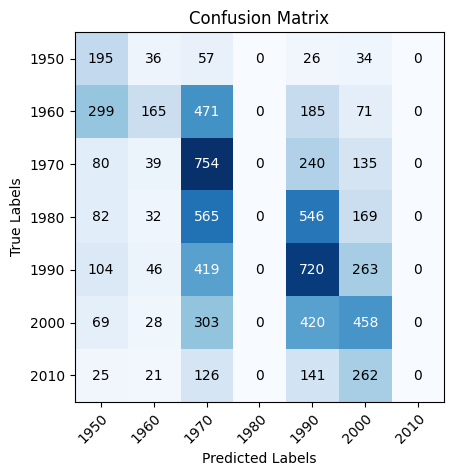

In [ ]:
fig, ax = plot_confusion_matrix(
    conf_mat=confusion_matrix,
    class_names=val_dataset.class_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()